In [26]:
import pandas as pd
import requests
import gzip
import io
from Bio import SeqIO


# -----------------------------
# 1. Download human STRING interactions
# -----------------------------
print("Downloading human STRING interactions...")
string_url = "https://stringdb-static.org/download/protein.links.detailed.v11.5/9606.protein.links.detailed.v11.5.txt.gz"

# Read in chunks to save memory
chunks = pd.read_csv(string_url, sep=" ", compression='gzip', chunksize=10**6)
filtered_chunks = []
for chunk in chunks:
    # Keep only high-confidence positives and low-confidence negatives
    filtered = chunk[(chunk['combined_score'] > 0.7) | (chunk['combined_score'] < 0.1)]
    filtered_chunks.append(filtered)

string_df = pd.concat(filtered_chunks)
print(f"Filtered STRING interactions: {len(string_df)}")

# -----------------------------
# 2. Map STRING protein IDs to UniProt IDs
# -----------------------------
print("Downloading STRING protein info for mapping...")
string_info_url = "https://stringdb-static.org/download/protein.info.v11.5/9606.protein.info.v11.5.txt.gz"
string_info = pd.read_csv(string_info_url, sep="\t")
string_info


Filtered STRING interactions: 11938498


,#string_protein_id,preferred_name,protein_size,annotation
0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,9606.ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...
3,9606.ENSP00000001146,CYP26B1,512,Cytochrome P450 26B1; Involved in the metaboli...
4,9606.ENSP00000002125,NDUFAF7,441,"Protein arginine methyltransferase NDUFAF7, mi..."
...,...,...,...,...
19561,9606.ENSP00000485671,ENSG00000280273,120,HCG1991042
19562,9606.ENSP00000485672,ENSG00000279458,86,annotation not available
19563,9606.ENSP00000485673,ENSG00000279988,243,annotation not available
19564,9606.ENSP00000485675,ENSG00000280116,84,annotation not available


In [27]:
import requests
import gzip
import io
from Bio import SeqIO
import pandas as pd


# Download human reference proteome from UniProt
print("Downloading human reference proteome...")
url = "https://rest.uniprot.org/uniprotkb/stream?compressed=true&format=fasta&query=(proteome:UP000005640)"
r = requests.get(url)
r.raise_for_status()

# Parse FASTA into gene-to-sequence map
gene_to_seq = {}
with gzip.open(io.BytesIO(r.content), "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        header = record.description
        seq = str(record.seq)
        gene = None
        for token in header.split():
            if token.startswith("GN="):
                gene = token.split("=")[1]
                break
        if gene and gene not in gene_to_seq:
            gene_to_seq[gene] = seq

print(f"Total genes mapped from proteome: {len(gene_to_seq)}")

# Map sequences to STRING preferred_name
string_info["seq"] = string_info["preferred_name"].map(gene_to_seq)

# Save to CSV
string_info.to_csv("string_info_with_sequences.csv", index=False)
print(f"Saved sequences for {string_info['seq'].notna().sum()} proteins")


Total genes mapped from proteome: 20575
Saved sequences for 17796 proteins


In [4]:
string_df

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,9606.ENSP00000000233,9606.ENSP00000379496,0,0,0,54,0,0,144,155
1,9606.ENSP00000000233,9606.ENSP00000314067,0,0,0,0,180,0,61,197
2,9606.ENSP00000000233,9606.ENSP00000263116,0,0,0,62,152,0,101,222
3,9606.ENSP00000000233,9606.ENSP00000361263,0,0,0,0,161,0,64,181
4,9606.ENSP00000000233,9606.ENSP00000409666,0,0,0,82,213,0,72,270
...,...,...,...,...,...,...,...,...,...,...
11938493,9606.ENSP00000485678,9606.ENSP00000354800,0,0,0,213,0,0,0,213
11938494,9606.ENSP00000485678,9606.ENSP00000308270,0,0,0,152,0,0,0,151
11938495,9606.ENSP00000485678,9606.ENSP00000335660,0,0,0,182,0,0,0,181
11938496,9606.ENSP00000485678,9606.ENSP00000300127,0,0,0,155,0,0,0,154


In [30]:
map_df = string_info[["#string_protein_id", "preferred_name", "seq"]]

# Merge mappings
string_merge_df = string_df.merge(map_df, left_on="protein1", right_on="#string_protein_id", how="left")
string_merge_df = string_merge_df.merge(map_df, left_on="protein2", right_on="#string_protein_id", how="left", suffixes=("_a", "_b"))

# Keep only UniProt IDs and experimental score
string_merge_df = string_merge_df[["preferred_name_a", "preferred_name_b", "seq_a", "seq_b", "combined_score"]].dropna()
string_merge_df["combined_score"] = string_merge_df["combined_score"] / 1000.0  # Normalize
string_merge_df.rename(columns={'combined_score': 'score', 'preferred_name_a': 'seq_name_a', 'preferred_name_b': 'seq_name_b'}, inplace=True)
string_merge_df

,seq_name_a,seq_name_b,seq_a,seq_b,score
0,ARF5,PDE1C,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MESPTKEIEEFESNSLKYLQPEQIEKIWLRLRGLRKYKKTSQRLRS...,0.155
1,ARF5,PAK2,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MSDNGELEDKPPAPPVRMSSTIFSTGGKDPLSANHSLKPLPSVPEE...,0.197
2,ARF5,RAB36,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MRSSLTPLGPPVSRDRVIASFPKWYTPEACLQLREHFHGQVSAACQ...,0.222
3,ARF5,RAPGEF1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MDTDSQRSHLSSFTMKLMDKFHSPKIKRTPSKKGKPAEVSVKIPEK...,0.181
4,ARF5,SUMO3,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MSEEKPKEGVKTENDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAY...,0.270
...,...,...,...,...,...
11938493,OR6Q1,OR5D13,MQPYTKNWTQVTEFVMMGFAGIHEAHLLFFILFLTMYLFTLVENLA...,MMASERNQSSTPTFILLGFSEYPEIQVPLFLVFLFVYTVTVVGNLG...,0.213
11938494,OR6Q1,OR5B3,MQPYTKNWTQVTEFVMMGFAGIHEAHLLFFILFLTMYLFTLVENLA...,MENKTEVTQFILLGLTNDSELQVPLFITFPFIYIITLVGNLGIIVL...,0.151
11938495,OR6Q1,KRTAP19-2,MQPYTKNWTQVTEFVMMGFAGIHEAHLLFFILFLTMYLFTLVENLA...,MCYGYGCGCGSFCRLGYGCGYEGCRYGCGHRGCGDGCCCPSCYRRY...,0.181
11938496,OR6Q1,OR4D6,MQPYTKNWTQVTEFVMMGFAGIHEAHLLFFILFLTMYLFTLVENLA...,MDQINHTNVKEFFFLELTRSRELEFFLFVVFFAVYVATVLGNALIV...,0.154


In [105]:
# Remove long sequences
string_filt_df = string_merge_df[
    (string_merge_df['seq_a'].str.len() <= 2000) &
    (string_merge_df['seq_b'].str.len() <= 2000)
].copy()
string_filt_df

,seq_name_a,seq_name_b,seq_a,seq_b,score
0,ARF5,PDE1C,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MESPTKEIEEFESNSLKYLQPEQIEKIWLRLRGLRKYKKTSQRLRS...,0.155
1,ARF5,PAK2,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MSDNGELEDKPPAPPVRMSSTIFSTGGKDPLSANHSLKPLPSVPEE...,0.197
2,ARF5,RAB36,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MRSSLTPLGPPVSRDRVIASFPKWYTPEACLQLREHFHGQVSAACQ...,0.222
3,ARF5,RAPGEF1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MDTDSQRSHLSSFTMKLMDKFHSPKIKRTPSKKGKPAEVSVKIPEK...,0.181
4,ARF5,SUMO3,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MSEEKPKEGVKTENDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAY...,0.270
...,...,...,...,...,...
11938493,OR6Q1,OR5D13,MQPYTKNWTQVTEFVMMGFAGIHEAHLLFFILFLTMYLFTLVENLA...,MMASERNQSSTPTFILLGFSEYPEIQVPLFLVFLFVYTVTVVGNLG...,0.213
11938494,OR6Q1,OR5B3,MQPYTKNWTQVTEFVMMGFAGIHEAHLLFFILFLTMYLFTLVENLA...,MENKTEVTQFILLGLTNDSELQVPLFITFPFIYIITLVGNLGIIVL...,0.151
11938495,OR6Q1,KRTAP19-2,MQPYTKNWTQVTEFVMMGFAGIHEAHLLFFILFLTMYLFTLVENLA...,MCYGYGCGCGSFCRLGYGCGYEGCRYGCGHRGCGDGCCCPSCYRRY...,0.181
11938496,OR6Q1,OR4D6,MQPYTKNWTQVTEFVMMGFAGIHEAHLLFFILFLTMYLFTLVENLA...,MDQINHTNVKEFFFLELTRSRELEFFLFVVFFAVYVATVLGNALIV...,0.154


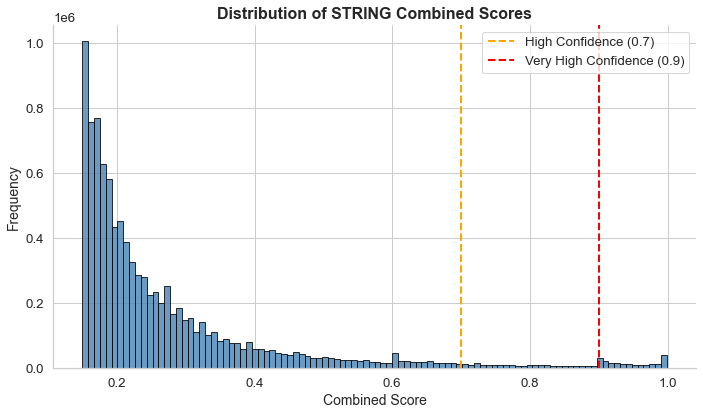

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn style for more elegant visuals
sns.set(style="whitegrid", font_scale=1.2)

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(string_filt_df['score'], bins=100, color='steelblue', edgecolor='black', alpha=0.8)

# Add labels and title
plt.title("Distribution of STRING Combined Scores", fontsize=16, weight='bold')
plt.xlabel("Combined Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Optional: add vertical lines for thresholds
plt.axvline(x=0.7, color='orange', linestyle='--', linewidth=2, label='High Confidence (0.7)')
plt.axvline(x=0.9, color='red', linestyle='--', linewidth=2, label='Very High Confidence (0.9)')

# Add legend
plt.legend()

# Remove top and right spines
sns.despine()

# Show the plot
plt.tight_layout()
plt.savefig('string_combined_score_hist.png', dpi=150, bbox_inches='tight')
plt.show()


In [74]:
# Assign labels
# def assign_label(score):
#     if score > 0.75:
#         return 1
#     elif score < 0.16:
#         return 0
#     else:
#         return float("nan")
# interactions = string_merge_df.copy()

# interactions["label"] = interactions["score"].apply(assign_label)
# interactions = interactions.dropna()
# interactions

In [108]:
interactions = string_filt_df.copy()
interactions = interactions.sort_values(by='score', ascending=True)
n = 500000
top = interactions.head(n).copy()
top['label'] = 1
bottom = interactions.tail(n).copy()
bottom['label'] = 0
interactions = pd.concat([top, bottom])
interactions

,seq_name_a,seq_name_b,seq_a,seq_b,score,label
1480846,EDAR,CP,MAHVGDCTQTPWLPVLVVSLMCSARAEYSNCGENEYYNQTTGLCQE...,MKILILGIFLFLCSTPAWAKEKHYYIGIIETTWDYASDHGEKKLIS...,0.150,1
10727266,GRK6,GPR139,MELENIVANTVLLKAREGGGGNRKGKSKKWRQMLQFPHISQCEELR...,MEHTHAHLAANSSLSWWSPGSACGLGFVPVVYYSLLLCLGLPANIL...,0.150,1
10727256,GRK6,OPN1SW,MELENIVANTVLLKAREGGGGNRKGKSKKWRQMLQFPHISQCEELR...,MSEEEFYLFKNISSVGPWDGPQYHIAPVWAFYLQAAFMGTVFLIGF...,0.150,1
7290657,KIF2C,ESCO1,MAMDSSLQARLFPGLAIKIQRSNGLIHSANVRTVNLEKSCVSVEWA...,MMSIQEKSKENSSKVTKKSDDKNSETEIQDSQKNLAKKSGPKETIK...,0.150,1
4258932,ATAD5,DHTKD1,MVGVLAMAAAAAPPPVKDCEIEPCKKRKKDDDTSTCKTITKYLSPL...,MASATAAAARRGLGRALPLFWRGYQTERGVYGYRPRKPESREPQGA...,0.150,1
...,...,...,...,...,...,...
231349,SNRPD3,SNRPB,MSIGVPIKVLHEAEGHIVTCETNTGEVYRGKLIEAEDNMNCQMSNI...,MTVGKSSKMLQHIDYRMRCILQDGRIFIGTFKAFDKHMNLILCDCD...,0.999,0
10771889,EID3,SMC6,MKMDVSVRAAGCSDDLSSGEADVDPKLLELTADEEKCRSIRRQYRQ...,MAKRKEENFSSPKNAKRPRQEELEDFDKDGDEDECKGTTLTAAEVG...,0.999,0
2711260,RPS3,RPL19,MAVQISKKRKFVADGIFKAELNEFLTRELAEDGYSGVEVRVTPTRT...,MSMLRLQKRLASSVLRCGKKKVWLDPNETNEIANANSRQQIRKLIK...,0.999,0
3998997,RNASEH2C,RNASEH2A,MESGDEAAIERHRVHLRSATLRDAVPATLHLLPCEVAVDGPAPVGR...,MDLSELERDNTGRCRLSSPVPAVCRKEPCVLGVDEAGRGPVLGPMV...,0.999,0


In [109]:
from collections import Counter
Counter(interactions['label'])

Counter({1: 500000, 0: 500000})

In [110]:
fname = f"human_ppi_interactions_{int(2*n/1000000)}M.csv"
interactions.to_csv(fname, index=False)
print(f"Saved dataset with {len(interactions)} interactions to {fname}")

Saved dataset with 1000000 interactions to human_ppi_interactions_1M.csv


In [112]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from huggingface_hub import create_repo, Repository
import shutil
import os

# -------------------------------------
# 1. Load interactions DataFrame
# -------------------------------------
interactions = pd.read_csv(fname)

# -------------------------------------
# 2. Stratified split (80/10/10)
# -------------------------------------
train_df, temp_df = train_test_split(
    interactions, test_size=0.2, stratify=interactions["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

# -------------------------------------
# 3. Convert to Hugging Face DatasetDict
# -------------------------------------
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
})

# -------------------------------------
# 4. Save dataset to disk
# -------------------------------------
dataset_dir = "string_ppi_human_1M"
dataset.save_to_disk(dataset_dir)

# -------------------------------------
# 5. Dataset description (README.md)
# -------------------------------------
dataset_description = """
# STRING PPI Human 1M

This dataset contains 1 million human protein–protein interactions (PPIs) derived from STRING v11.5.

**Columns**:
- `seq_a`, `seq_b`: Amino acid sequences of the interacting proteins (≤2048 AA).
- `seq_name_a`, `seq_name_b`: Protein names from STRING.
- `score`: Combined score from STRING (0–1000, normalized to 0–1). This score integrates various evidence channels (experimental data, text mining, co-expression, etc.) into a single confidence metric.
- `label`: Binary interaction label.
  - `1`: High-confidence positive interaction (STRING experimental score > 0.7).
  - `0`: Low-confidence negative interaction (STRING experimental score < 0.2).

**Processing Steps**:
- Downloaded human interactions from STRING (`9606.protein.links.detailed.v11.5.txt.gz`).
- Filtered by experimental score thresholds for positives/negatives.
- Retrieved protein sequences from UniProt by matching STRING protein names.
- Excluded sequences longer than 2048 amino acids.
- Balanced top and bottom 500k interactions by combined score.

Useful for training models for binary PPI prediction or embedding-based methods.

Source: [STRING Database v11.5](https://string-db.org).
"""

# -------------------------------------
# 6. Create and push to Hugging Face Hub
# -------------------------------------
repo_id = "vladak/string_ppi_human_1M"
local_repo_path = "string_ppi_human_1M_repo"
target_data_dir = os.path.join(local_repo_path, "data")

# Create and clone the repo (if not already exists)
create_repo(repo_id, repo_type="dataset", exist_ok=True)
repo = Repository(local_dir=local_repo_path, clone_from=repo_id, repo_type="dataset")

# Save README.md
readme_path = os.path.join(local_repo_path, "README.md")
with open(readme_path, "w") as f:
    f.write(dataset_description.strip())

# Ensure the data/ directory is clean
if os.path.exists(target_data_dir):
    shutil.rmtree(target_data_dir)

# Copy dataset files into data/ inside the repo
shutil.copytree(dataset_dir, target_data_dir)

# Commit and push to Hugging Face Hub
dataset.push_to_hub(repo_id)
# Add Readme.md manually


Saving the dataset (0/2 shards):   0%|          | 0/800000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/datasets/vladak/string_ppi_human_1M into local empty directory.


Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/vladak/string_ppi_human_1M/commit/fa592f5895ae5ec1c9cd5d902bacfb2cd79c4633', commit_message='Upload dataset', commit_description='', oid='fa592f5895ae5ec1c9cd5d902bacfb2cd79c4633', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/vladak/string_ppi_human_1M', endpoint='https://huggingface.co', repo_type='dataset', repo_id='vladak/string_ppi_human_1M'), pr_revision=None, pr_num=None)

# STRING PPI Human 1M

This dataset contains 1 million human protein–protein interactions (PPIs) derived from STRING v11.5.

**Columns**:
- `seq_a`, `seq_b`: Amino acid sequences of the interacting proteins (≤2048 AA).
- `seq_name_a`, `seq_name_b`: Protein names from STRING.
- `score`: Combined score from STRING (0–1000, normalized to 0–1). This score integrates various evidence channels (experimental data, text mining, co-expression, etc.) into a single confidence metric.
- `label`: Binary interaction label.
  - `1`: High-confidence positive interaction (STRING experimental score > 0.7).
  - `0`: Low-confidence negative interaction (STRING experimental score < 0.2).

**Processing Steps**:
- Downloaded human interactions from STRING (`9606.protein.links.detailed.v11.5.txt.gz`).
- Filtered by experimental score thresholds for positives/negatives.
- Retrieved protein sequences from UniProt by matching STRING protein names.
- Excluded sequences longer than 2048 amino acids.
- Balanced top and bottom 500k interactions by combined score.

Useful for training models for binary PPI prediction or embedding-based methods.

Source: [STRING Database v11.5](https://string-db.org).


In [ ]:
from datasets import load_dataset

# Load the dataset
ds = load_dataset("vladak/string_ppi_human_1M")

# Print available splits
print(ds)

In [66]:
# def get_uniprot_sequence(gene_name):
#     url = f"https://rest.uniprot.org/uniprotkb/search?query=gene_exact:{gene_name}+AND+organism_id:9606&format=fasta"
#     r = requests.get(url)
#     if r.ok and r.text:
#         # Extract sequence from FASTA
#         lines = r.text.split("\n")
#         seq = "".join([line for line in lines if not line.startswith(">")])
#         return seq
#     else:
#         return None

# # Example
# print(get_uniprot_sequence("FKBP4"))
# print(get_uniprot_sequence("NDUFAF7"))


MTAEEMKATESGAQSAPLPMEGVDISPKQDEGVLKVIKREGTGTEMPMIGDRVFVHYTGWLLDGTKFDSSLDRKDKFSFDLGKGEVIKAWDIAIATMKVGEVCHITCKPEYAYGSAGSPPKIPPNATLVFEVELFEFKGEDLTEEEDGGIIRRIQTRGEGYAKPNEGAIVEVALEGYYKDKLFDQRELRFEIGEGENLDLPYGLERAIQRMEKGEHSIVYLKPSYAFGSVGKEKFQIPPNAELKYELHLKSFEKAKESWEMNSEEKLEQSTIVKERGTVYFKEGKYKQALLQYKKIVSWLEYESSFSNEEAQKAQALRLASHLNLAMCHLKLQAFSAAIESCNKALELDSNNEKGLFRRGEAHLAVNDFELARADFQKVLQLYPNNKAAKTQLAVCQQRIRRQLAREKKLYANMFERLAEEENKAKAEASSGDHPTDTEMKEEQKSNTAGSQSQVETEAMETPPVNTIGEKDTSQPQQEWEKNLRENLDSVIQIRQQPRDPPTETLELEVSPDPASQILEHTQGAEKLVAELEGDSHKSHGSTSQMPETLQASDLWYCPDGSFVKKIVIRGHGLDKPKLGSCCRVLALGFPFGSGPPEGWTELTMGVGPWREETWGELIEKCLESMCQGEEAELQLPGHSGPPVRLTLASFTQGRDSWELETSEKEALAREERARGTELFRAGNPEGAARCYGRALRLLLTLPPPGPPERTVLHANLAACQLLLGQPQLAAQSCDRVLEREPGHLKALYRRGVAQAALGNLEKATADLKKVLAIDPKNRAAQEELGKVVIQGKNQDAGLAQGLRKMFGMTAEEMKATESGAQSAPLPMEGVDISPKQDEGVLKIIGDLKRLLQRLSCGMMPMIGDRVFVHYTGWLLDGTKFDSSLDRKDKFSFDLGKGEVIKAWDIAIATMKVGEVCHITCKPEYAYGSAGSPPKIPPNATLVFEXKEEQKSNTAGSQSQIRKPRLRSXVNDFELARADFQKVLQLYPNNKAAKTQLAVC